## Komoran을 이용한 형태소 분석

In [1]:
# 필요한 라이브러리 설치
!pip install konlpy
!pip install nltk
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install WordCloud
!pip install matplotlib

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     |████████████████████████████████| 19.4 MB 78.5 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 448 kB 66.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-5llj80jp
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-5llj80jp
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=a16a3d58b6c65b40102a8aadfdd9a7cd7ec04eeba51a6eb562045f7c3c6d1707
  Stored in directory: /tmp/pip-ephem-wheel-cache-ape1036n/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts

In [3]:
# 드라이브에 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 필요한 패키지 및 함수 import
import io # io없이 pandas만 import할 경우 오류 발생
import pandas as pd
import csv
from konlpy.tag import Komoran #, Okt
from hanspell import spell_checker
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import random
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#pd.read_csv로 csv파일 불러오기
data = pd.read_csv('/content/drive/Shareddrives/언어의미와정보 데이터캡스톤디자인/리뷰 데이터/NH농협은행/raw/NH농협.csv')
data.head()

# 'date' 열 형식을 datetime으로 변환
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
# print(data['date'].dtypes) # 타입 변환이 잘 됐는지 확인

# 특정 연도 설정 및 데이터 추출
target_year = 2021
data_2021 = data.query('date.dt.year == @target_year')
print("총", len(data_2021), "개의 데이터가 있습니다.")

# 별점 별 분류
star_1 = data_2021.query('score == 1')
print("별 1점 리뷰는", len(star_1), "개 입니다.")

star_2 = data_2021.query('score == 2')
print("별 2점 리뷰는", len(star_2), "개 입니다.")

star_3 = data_2021.query('score == 3')
print("별 3점 리뷰는", len(star_3), "개 입니다.")

star_4 = data_2021.query('score == 4')
print("별 4점 리뷰는", len(star_4), "개 입니다.")

star_5 = data_2021.query('score == 5')
print("별 5점 리뷰는", len(star_5), "개 입니다.")

# 리뷰 내용만 추출해서 리스트로 변환
star_1_comments = star_1['comment'].values.tolist()
star_2_comments = star_2['comment'].values.tolist()
star_3_comments = star_3['comment'].values.tolist()
star_4_comments = star_4['comment'].values.tolist()
star_5_comments = star_5['comment'].values.tolist()

# 모든 데이터가 제대로 분류/변환되었는지 확인
review_cnt = len(star_1) + len(star_2) + len(star_3) + len(star_4) + len(star_5)
review_cnt2 = len(star_1_comments) + len(star_2_comments) + len(star_3_comments) + len(star_4_comments) + len(star_5_comments)

if (len(data_2021) == review_cnt) & (review_cnt == review_cnt2):
  print("Success!")
else:
  print("failed..")

총 8448 개의 데이터가 있습니다.
별 1점 리뷰는 1072 개 입니다.
별 2점 리뷰는 101 개 입니다.
별 3점 리뷰는 253 개 입니다.
별 4점 리뷰는 1090 개 입니다.
별 5점 리뷰는 5932 개 입니다.
Success!


In [6]:
# 데이터를 변환할 평점 데이터 선택
comments = star_5_comments

In [7]:
# 텍스트에 포함되어 있는 특수 문자 제거
specialChar = '!@#$%^&*()_{}[]\|;:''"<>?/'

for i in range(len(comments)):
  comments[i] = ''.join(c for c in comments[i] if c not in specialChar)
#print(comments)

# 이모지 제거
def rmEmoji(text):
  only_BMP_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
                           "]+", flags=re.UNICODE)
  return only_BMP_pattern.sub(r'',text) # BMP characters만

for i in range(len(comments)):
  comments[i] = rmEmoji(comments[i])
#print(comments)

'''
# 맞춤법 검사
for i in range(len(comments)):
  spelled_sent = spell_checker.check(comments[i])
  checked_sent = spelled_sent.checked
  comments[i] = checked_sent
'''

'\n# 맞춤법 검사\nfor i in range(len(comments)):\n  spelled_sent = spell_checker.check(comments[i])\n  checked_sent = spelled_sent.checked\n  comments[i] = checked_sent\n'

In [8]:
# NLTK 사용법
'''
text = "NLTK는 Natural Language Toolkit의 줄임말입니다. Python 프로그래밍 언어로 작성된 영어의 기호 및 통계 자연 언어 처리를위한 라이브러리 및 프로그램 모음입니다"
print(word_tokenize(text))
print(sent_tokenize(text))
'''

# NLTK 문장 분리
sent_token = []

for i in range(len(comments)):
  line = []
  for comment in sent_tokenize(comments[i]):
    line.append(comment)
  sent_token.append(line)
#print(sent_token)

# sent_token.csv 파일 생성
f = open("sent_token.csv", "w")
writer = csv.writer(f)

for row in sent_token:
  writer.writerow(row)

f.close()


# 고려하는 품사만 tag로 선택
'''
긍정지정사(VCP), 부정지정사(VCN)
일반명사(NNG), *고유명사(NNP)*, 동사(VV), 형용사(VA), 부사(MAG)
수사(NR), 감탄사(IC), 어근(XR), 보조 용언(VX)
'''
tag_list = ['VCP','VCN',
            'NNG','NNP','VV','VA','MAG',
            'NR','IC','XR','VX']

def remove_word_by_tag(token,tag):
  temp = list()
  for k in range(len(token)):
    if token[k][1] in tag:
      temp.append(token[k])
    else:
      continue
  return temp

# komoran 함수 정리
'''
komoran = Komoran()
komoran.morphs() # 문장을 형태소 단위 나누기
komoran.nouns() # 문장에서 명사만 추출
komoran.pos() # 형태소의 품사까지 반환 ('형태소','품사')
'''

# 형태소 및 품사 분리 -> 리스트 형태 저장
morph_token = []
komoran = Komoran() # komoran 객체 생성

for i in range(len(sent_token)):
  line = []
  for j in sent_token[i]:
    token = komoran.pos(j)
    token = remove_word_by_tag(token,tag_list)
    line.append(token)
  morph_token.append(line)
#print(len(morph_token))
#print(morph_token)


# morph_token.csv 파일 생성
f = open("morph_token.csv", "w")
writer = csv.writer(f)

for row in morph_token:
  writer.writerow(row)

f.close()

## WORD CLOUD


WORD LIST를 출력합니다.
['좋', '사용', '쉽', '빠르', '편리', '좋', '사용', '편리', '좋', '좋', '로딩', '화면', '이안', '좋', '급하', '처리', '조회', '때', '넘', '좋', '갓', '농협', '좋', '아', '정말', '설정', '완료', '최고', '예', '편하', '사용', '있', '좋', '편안', '사용', '신용카드', '사용', '후', '알람', '때', '누적', '사용량', '얼마', '인지', '표시', '주', '좋', '같', '편하', '잘', '사용', '있', '좋', '컴퓨터', '안', '좋', '잘', '개발자', '화이팅', '매우', '만족', '하오', '살짝', '정도', '애', '용하', '문제없', '사용', '않', '계좌', '수도', '만족', '처음이라서', '쉽', '않', '농협', '계좌', '편리', '좋', '좋', '스마트', '뱅킹', '자주', '이용', '일상생활', '더욱더', '많이', '편리', '지', '앞', '끝', '스마트', '뱅킹', '이용', '고맙', '정복', '아직', '학생', '중학교', '농협', '카드', '사용', '보', '인터넷', '결제', '완전', '편리', '엄청', '이용', '내역', '완전', '얼마', '확인', '가능', '좋', '얼마', '편하', '완전', '잘', '이용', '합', '당', '좋', '좋', '계좌', '이체', '이체', '내역', '당연히', '편리', '지금', '잘', '있', '좋', '베리', '베리', '굿', '안전', '편리', '너무', '편하', '간편', '잘', '있', '만족', '아주', '좋', '넘', '편리', '어렵', '않', '좋', '싶', '푸쉬', '알람', '적금', '만기', '다양', '알람', '추가', '고려', '주', '농협', '화이팅', '대출', '잘', '이자율', '상향', '소식', '편

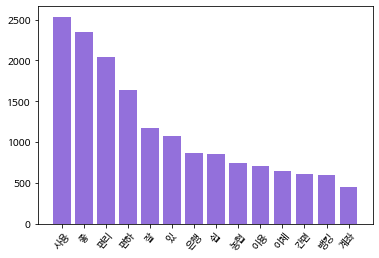

In [12]:
# 추가해야할 것
'''
# 사용자 사전 추가
# STOPWORDS LIST 생성
# stopwords 제거
'''

# 분석 대상에 포함된 품사의 단어만 추출
'''
일반명사(NNG), 고유명사(NNP), 형용사(VA), 부사(MAG)
어근(XR), 보조 용언(VX)
'''
tag_list2 = ['NNG','NNP','VA','MAG',
            'XR','VX']

target_list = []
for i in range(len(sent_token)):
  line = []
  for j in sent_token[i]:
    token = komoran.pos(j)
    token = remove_word_by_tag(token,tag_list2)
    line.append(token)
  target_list.append(line)
#print(target_list)

# 품사를 제거하고 단어만 리스트에 추가
word_list = []
for i in range(len(target_list)):
  for j in target_list[i]:
    for k in j:
      word_list.append(k[0])

print("WORD LIST를 출력합니다.")
print(word_list)


# 워드 클라우드 생성
wordcloud = WordCloud(font_path='/content/NanumGothicCoding.ttf',
                      width = 800, height = 800,
                      background_color = "black")

def purple_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(random.randint(212,313),random.randint(26,32),random.randint(45,80)))

# 모든 단어에 대해 생성
count = Counter(word_list)
wc = wordcloud.generate_from_frequencies(count)
wc.recolor(color_func = purple_color_func)
wc.to_file('wordcloud.jpg')

# 가장 많이 나온 단어 n개에 대해 생성
n = 40
tags = count.most_common(n)
wc2 = wordcloud.generate_from_frequencies(dict(tags))
wc2.recolor(color_func = purple_color_func)
wc2.to_file('wordcloud2.jpg')

# 단어 빈도수에 따른 히스토그램 그리기
temp = {i: j for i, j in count.items() if j >= 400} # 딕셔너리 컴프리헨션
temp1 = sorted(temp.items(), key=(lambda x: x[1]), reverse=True)
temp2 = dict(temp1)

plt.rc('font', family='NanumBarunGothic') 
plt.xticks(rotation=50)
plt.bar(temp2.keys(), temp2.values(), color='mediumpurple')
plt.savefig('histogram.jpg')